# Explore here

In [1]:
!pip install kagglehub
import kagglehub

path = kagglehub.dataset_download("salader/dogs-vs-cats")

print("Path to dataset files:", path)

Path to dataset files: /home/vscode/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1


In [2]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import zipfile 

2025-07-20 21:24:43.756072: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-20 21:24:43.780495: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 21:24:43.972947: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 21:24:44.112578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753046684.389381   15431 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753046684.45

# --- Configuration ---

In [5]:
IMAGE_WIDTH, IMAGE_HEIGHT = 200, 200
BATCH_SIZE = 32
EPOCHS = 10

# Define local directories for our structured dataset
BASE_DATA_DIR = 'dogs_vs_cats_dataset'
TRAIN_DIR = os.path.join(BASE_DATA_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DATA_DIR, 'validation')

# Model saving path
MODEL_SAVE_PATH = 'trained_models/dogs_vs_cats_vgg_like.h5'
CHECKPOINT_FILEPATH = 'trained_models/best_model_checkpoint.h5'

# --- Step 1: Loading the dataset using kagglehub ---

In [4]:
download_path = None

try:
    download_path = kagglehub.dataset_download("salader/dogs-vs-cats")
    print(f"Dataset downloaded to: {download_path}")

    # Based on your latest 'ls -l' output, the raw images are directly within
    # 'dogs_vs_cats/train/' organized into 'cats/' and 'dogs/' subfolders.
    # We will use this 'train' folder from the cache as our source.
    SOURCE_TRAIN_CATS_DIR = os.path.join(download_path, 'dogs_vs_cats', 'train', 'cats')
    SOURCE_TRAIN_DOGS_DIR = os.path.join(download_path, 'dogs_vs_cats', 'train', 'dogs')

    if not os.path.isdir(SOURCE_TRAIN_CATS_DIR) or not os.path.isdir(SOURCE_TRAIN_DOGS_DIR):
        print(f"CRITICAL ERROR: Expected source directories not found or incomplete:")
        print(f"  Cats source: {SOURCE_TRAIN_CATS_DIR}")
        print(f"  Dogs source: {SOURCE_TRAIN_DOGS_DIR}")
        print("Please manually verify the structure of the KaggleHub downloaded dataset.")
        exit()

    print(f"Identified source directories for images:")
    print(f"  Cats: {SOURCE_TRAIN_CATS_DIR}")
    print(f"  Dogs: {SOURCE_TRAIN_DOGS_DIR}")

except Exception as e:
    print(f"Error during dataset download or initial path identification: {e}")
    print("Please ensure 'kagglehub' is installed and your Kaggle API credentials are correctly set up (kaggle.json in ~/.kaggle/).")
    exit()

# --- Prepare local directory structure for ImageDataGenerator ---
print("\n--- Preparing local directory structure for ImageDataGenerator ---")

# Clean up existing structure if it exists to avoid old files
if os.path.exists(BASE_DATA_DIR):
    print(f"Removing existing '{BASE_DATA_DIR}' directory for a clean start...")
    shutil.rmtree(BASE_DATA_DIR)

os.makedirs(os.path.join(TRAIN_DIR, 'dogs'), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, 'cats'), exist_ok=True)
os.makedirs(os.path.join(VALIDATION_DIR, 'dogs'), exist_ok=True)
os.makedirs(os.path.join(VALIDATION_DIR, 'cats'), exist_ok=True)

# List all image files from the source 'cats' and 'dogs' directories
all_cat_files = [f for f in os.listdir(SOURCE_TRAIN_CATS_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
all_dog_files = [f for f in os.listdir(SOURCE_TRAIN_DOGS_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

random.shuffle(all_cat_files)
random.shuffle(all_dog_files)

print(f"Found {len(all_cat_files)} cat images and {len(all_dog_files)} dog images in source.")

# Define split ratio (e.g., 80% train, 20% validation)
train_split_ratio = 0.8

# Distribute cat images
num_train_cats = int(len(all_cat_files) * train_split_ratio)
for i, img_name in enumerate(all_cat_files):
    src_path = os.path.join(SOURCE_TRAIN_CATS_DIR, img_name)
    if i < num_train_cats:
        dst_path = os.path.join(TRAIN_DIR, 'cats', img_name)
    else:
        dst_path = os.path.join(VALIDATION_DIR, 'cats', img_name)
    try:
        shutil.copy(src_path, dst_path)
    except Exception as e:
        print(f"ERROR: Could not copy cat image '{img_name}': {e}")

# Distribute dog images
num_train_dogs = int(len(all_dog_files) * train_split_ratio)
for i, img_name in enumerate(all_dog_files):
    src_path = os.path.join(SOURCE_TRAIN_DOGS_DIR, img_name)
    if i < num_train_dogs:
        dst_path = os.path.join(TRAIN_DIR, 'dogs', img_name)
    else:
        dst_path = os.path.join(VALIDATION_DIR, 'dogs', img_name)
    try:
        shutil.copy(src_path, dst_path)
    except Exception as e:
        print(f"ERROR: Could not copy dog image '{img_name}': {e}")

print("Dataset successfully structured into local train/validation directories.")
print(f"  Training Cats: {len(os.listdir(os.path.join(TRAIN_DIR, 'cats')))}")
print(f"  Training Dogs: {len(os.listdir(os.path.join(TRAIN_DIR, 'dogs')))}")
print(f"  Validation Cats: {len(os.listdir(os.path.join(VALIDATION_DIR, 'cats')))}")
print(f"  Validation Dogs: {len(os.listdir(os.path.join(VALIDATION_DIR, 'dogs')))}")


Dataset downloaded to: /home/vscode/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1
Identified source directories for images:
  Cats: /home/vscode/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/train/cats
  Dogs: /home/vscode/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/train/dogs

--- Preparing local directory structure for ImageDataGenerator ---
Removing existing 'dogs_vs_cats_dataset' directory for a clean start...
Found 10000 cat images and 10000 dog images in source.
Dataset successfully structured into local train/validation directories.
  Training Cats: 8000
  Training Dogs: 8000
  Validation Cats: 2000
  Validation Dogs: 2000


# --- Step 2: Visualize the input information ---

Attempting to display 9 sample dogs images from dogs_vs_cats_dataset/train/dogs...


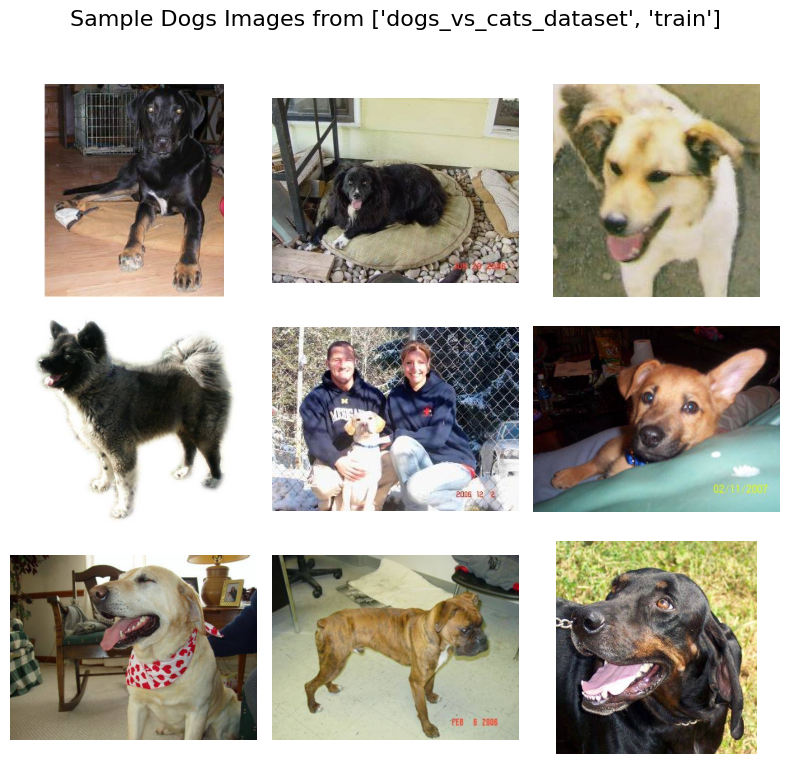

Attempting to display 9 sample cats images from dogs_vs_cats_dataset/train/cats...


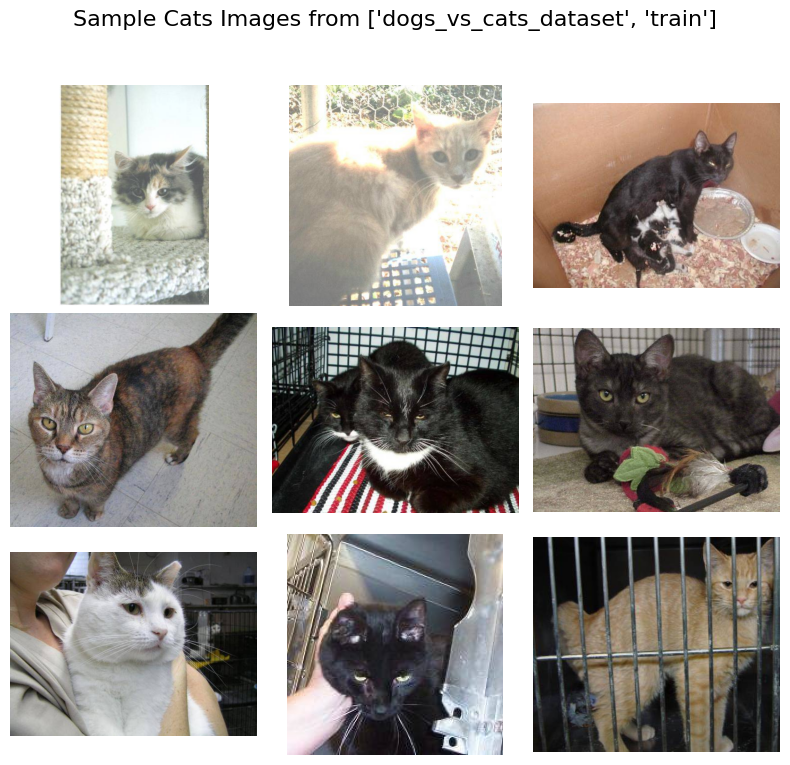


--- Setting up ImageDataGenerator ---
Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Class indices: {'cats': 0, 'dogs': 1}


In [5]:
def plot_sample_images(directory, class_name, num_images=9):
    """Plots a grid of sample images from a specified directory and class."""
    target_path = os.path.join(directory, class_name)
    print(f"Attempting to display {num_images} sample {class_name} images from {target_path}...")

    image_files = [f for f in os.listdir(target_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(image_files)

    if not image_files:
        print(f"No common image files found in {target_path} to display.")
        return

    plt.figure(figsize=(8, 8))
    plt.suptitle(f"Sample {class_name.capitalize()} Images from {directory.split(os.sep)[-2:]}", fontsize=16)

    displayed_count = 0
    for i in range(min(num_images, len(image_files))):
        img_path = os.path.join(target_path, image_files[i])
        try:
            img = mpimg.imread(img_path)
            plt.subplot(3, 3, displayed_count + 1)
            plt.imshow(img)
            plt.axis('off')
            displayed_count += 1
        except Exception as e:
            print(f"WARNING: Could not read or display image {img_path}: {e}")

    if displayed_count > 0:
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        plt.close()
        print(f"No images successfully displayed from {target_path}.")

plot_sample_images(TRAIN_DIR, 'dogs')
plot_sample_images(TRAIN_DIR, 'cats')


# --- Create ImageDataGenerator objects ---
print("\n--- Setting up ImageDataGenerator ---")

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, # Now pointing to your project's local organized data
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR, # Now pointing to your project's local organized data
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Class indices: {train_generator.class_indices}")


# --- Step 3: Build an ANN (CNN based on VGG16) ---

In [6]:
model = Sequential()
model.add(Conv2D(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/workspaces/Clasficador-de-Imagenes-Roza/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-20 21:22:02.297034: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    75,501,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,001,665 (408.18 MB)

 Trainable params: 107,001,665 (408.18 MB)

 Non-trainable params: 0 (0.00 B)

# --- Step 4: Optimize the above model with Callbacks ---

In [8]:
os.makedirs(os.path.dirname(CHECKPOINT_FILEPATH), exist_ok=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath=CHECKPOINT_FILEPATH, save_weights_only=False, monitor='val_accuracy',
    mode='max', save_best_only=True, verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', patience=10, mode='min',
    restore_best_weights=True, verbose=1
)

# Only fit if images were found
if train_generator.samples > 0:
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

    print("\n--- Training finished ---")

    print(f"Loading best model from: {CHECKPOINT_FILEPATH}")
    best_model = tf.keras.models.load_model(CHECKPOINT_FILEPATH)

    print("\n--- Evaluating the best model on the validation set ---")
    val_loss, val_accuracy = best_model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
    print(f"Best Model - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    print("\n--- Plotting training history ---")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


Epoch 1/50


: 